**Predicting Human Life Expectancy Based on Social services**

**Introduction**

In this exploratory data analysis, we aim to explore the relationship between life expectancy and social services across various countries. Life expectancy is a critical metric reflecting the overall health and well-being of a population, while social services encompass a wide range of factors such as healthcare access, education, economic stability, and social support systems.

The question we aim to answer with this project is "What factors of social service affect life expectancy, and what is their relationship?". In order to do this we will build a predictive model that uses regression to predict the life expectancy of a country's population based on various factors we think would have a correlation.

The dataset used for this analysis is the "Global Country Information Dataset 2023", taken from Kaggle. It contains information on key social service indicators and life expectancy statistics for multiple countries for the year 2023.

https://www.kaggle.com/datasets/nelgiriyewithana/countries-of-the-world-2023

In [22]:
# load the necessary libraries and set seed to begin
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1689)

**Preliminary Data Analysis**

In [25]:
# data is a .csv file so it can be read using read_csv
url <- "https://raw.githubusercontent.com/mariemkandeel/Group-39-Project/main/Data/world-data-2023.csv"
data <- read_csv(url)
data

Rows: 195 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (19): Country, Abbreviation, Agricultural Land( %), Capital/Major City, ...
dbl  (9): Birth Rate, Calling Code, Fertility Rate, Infant mortality, Life e...
num  (7): Density
(P/Km2), Land Area(Km2), Armed Forces size, Co2-Emissions,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Country,Density (P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,⋯,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Afghanistan,60,AF,58.10%,652230,323000,32.49,93,Kabul,8672,⋯,78.40%,0.28,38041754,48.90%,9.30%,71.40%,11.12%,9797273,33.93911,67.709953
Albania,105,AL,43.10%,28748,9000,11.78,355,Tirana,4536,⋯,56.90%,1.20,2854191,55.70%,18.60%,36.60%,12.33%,1747593,41.15333,20.168331
Algeria,18,DZ,17.40%,2381741,317000,24.28,213,Algiers,150006,⋯,28.10%,1.72,43053054,41.20%,37.20%,66.10%,11.70%,31510100,28.03389,1.659626
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yemen,56,YE,44.60%,527968,40000,30.45,967,Sanaa,10609,⋯,81.00%,0.31,29161922,38.00%,NA,26.60%,12.91%,10869523,15.55273,48.51639
Zambia,25,ZM,32.10%,752618,16000,36.19,260,Lusaka,5141,⋯,27.50%,1.19,17861030,74.60%,16.20%,15.60%,11.43%,7871713,-13.13390,27.84933
Zimbabwe,38,ZW,41.90%,390757,51000,30.68,263,Harare,10983,⋯,25.80%,0.21,14645468,83.10%,20.70%,31.60%,4.95%,4717305,-19.01544,29.15486


To decide which columns to use as predictors, we examined the dataset and made a few guesses, we then checked to see if these were backed by scientific research. The following are the columns we chose, along with their citations for proof of correlation.

- "Gross tertiary education enrollment (%)" (Hummer & Hernandez, 2015)
-  "Physicians per thousand" (You & Donelly, 2022)
-  "Minimum wage" (Lenhart, 2017)

As we started to visualize the data, we realised that we first had to clean it, since the column names had spaces in them and the minimum wage and education enrollment columns had symbols in them.

Cleaning does not affect the testing data set, rather only makes it usable.

In [24]:
data_cleaned <- rename(data, life_expectancy = "Life expectancy", education_enrollment = "Gross tertiary education enrollment (%)", physicians_per_thousand = "Physicians per thousand", min_wage = "Minimum wage")|>
mutate(education_enrollment = substr(education_enrollment, 1, nchar(education_enrollment)-1)) |>
mutate(education_enrollment = as.double(education_enrollment))|>
mutate(min_wage = substr(min_wage, 2, nchar(min_wage))) |>
mutate(min_wage = as.double(min_wage)) |>
select(Country, min_wage, life_expectancy, physicians_per_thousand, education_enrollment)
data_cleaned

Country,min_wage,life_expectancy,physicians_per_thousand,education_enrollment
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,0.43,64.5,0.28,9.7
Albania,1.12,78.5,1.20,55.0
Algeria,0.95,76.7,1.72,51.4
⋮,⋮,⋮,⋮,⋮
Yemen,NA,66.1,0.31,10.2
Zambia,0.24,63.5,1.19,4.1
Zimbabwe,NA,61.2,0.21,10.0


Before starting to visualize the data, let us first split it into training and testing, using a split of 0.75 and setting strata to life_expectancy.
This ensures that life_expectancy is evenly distributed among the two splits.

In [14]:
data_split <- initial_split(data_cleaned, prop = 0.75, strata = life_expectancy)
data_training <- training(data_split)
data_testing <- testing(data_split)
data_training

min_wage,life_expectancy,physicians_per_thousand,education_enrollment
<dbl>,<dbl>,<dbl>,<dbl>
0.43,64.5,0.28,9.7
0.39,61.5,0.08,12.3
NA,61.2,0.10,6.1
⋮,⋮,⋮,⋮
NA,83.6,4.30,59.6
10.13,81.3,2.81,60.0
1.66,77.8,5.05,63.1


A summary of the training data is given below

In [16]:
data_summary <- data_training |>
summarize(across(min_wage:education_enrollment, mean, na.rm = TRUE)) |>
pivot_longer(cols = min_wage:education_enrollment, names_to = "Variable", values_to = "Average")|>
mutate(Missing_Observations = colSums(is.na(data_training)))
data_summary

Variable,Average,Missing_Observations
<chr>,<dbl>,<dbl>
min_wage,2.179464,33
life_expectancy,72.122143,5
physicians_per_thousand,1.902908,4
education_enrollment,39.373529,9


Continuing the preliminary data analysis, visualizations of the chosen features and their correlation with life expectancy are performed using the training data to affirm the correlations suggested. The axes are scaled to develop a clearer visualization of the points.

Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 34 rows containing missing values (`geom_point()`).”


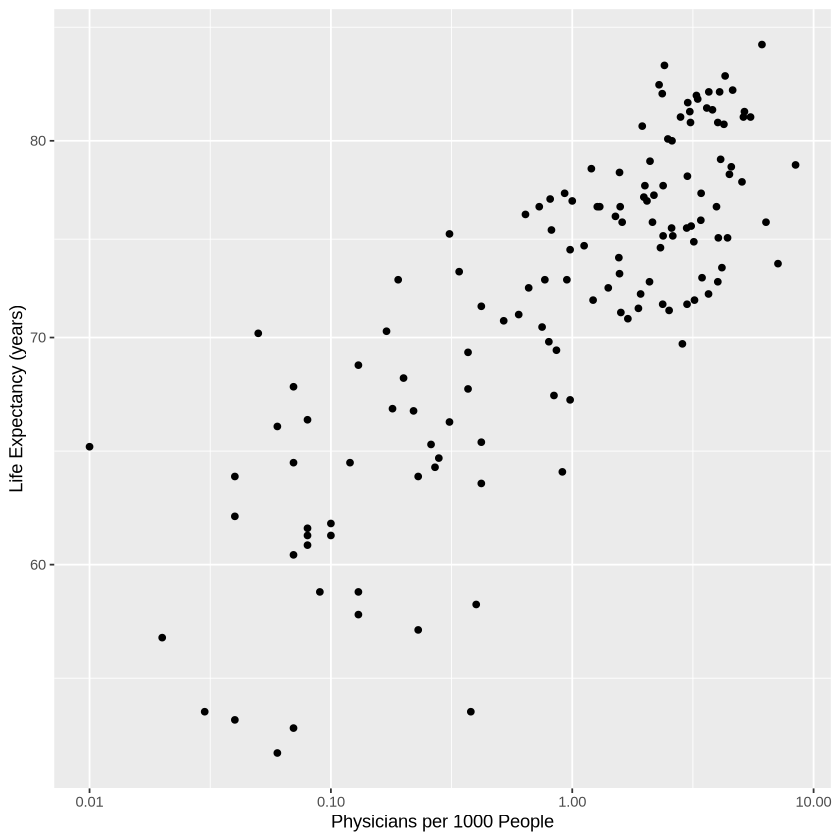

Warning message:
“Removed 9 rows containing missing values (`geom_point()`).”


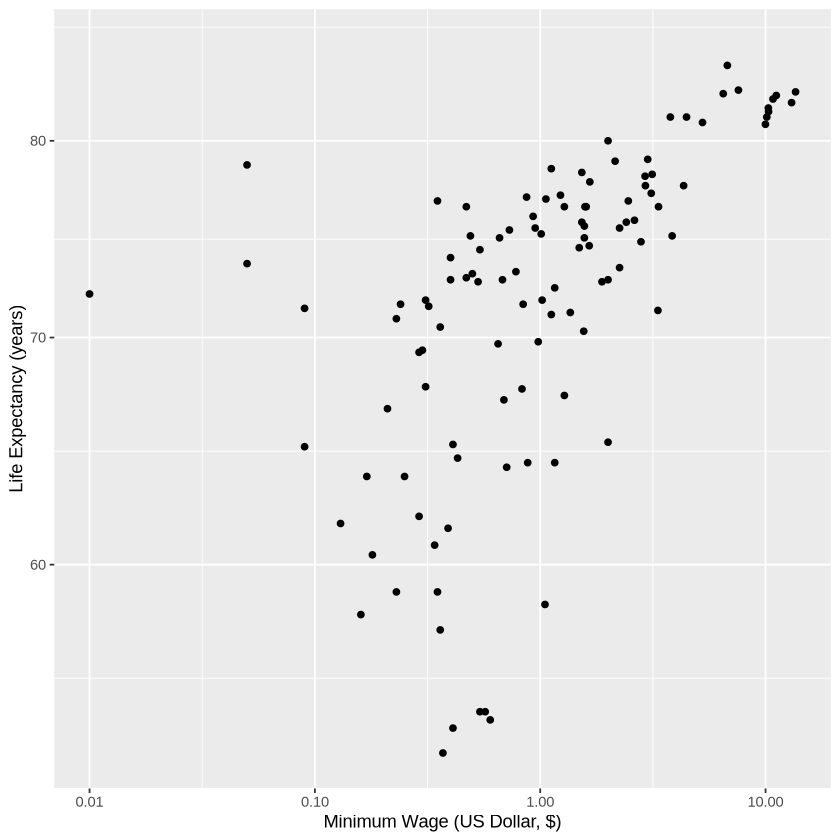

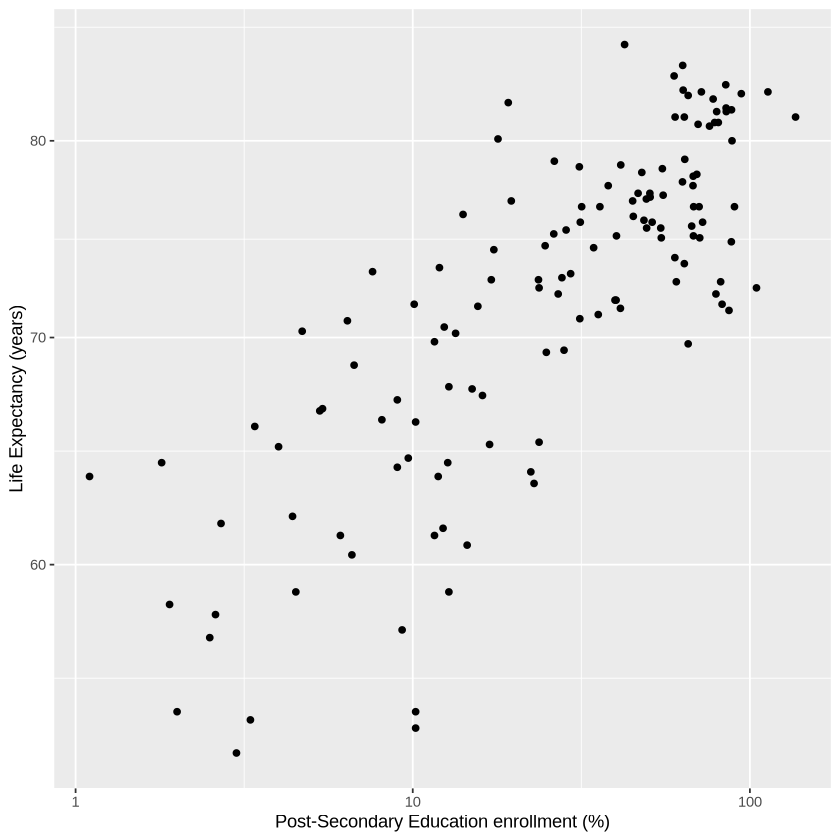

In [21]:
physicians_plot <- ggplot(data_training, aes(x = physicians_per_thousand, y = life_expectancy)) +
    geom_point() + 
    scale_x_log10() + 
    scale_y_log10() + 
    labs(x = "Physicians per 1000 People", y = "Life Expectancy (years)")
physicians_plot

min_wage_plot <- ggplot(data_training, aes(x = min_wage, y = life_expectancy)) +
    geom_point() + 
    scale_x_log10() + 
    scale_y_log10() + 
    labs(x = "Minimum Wage (US Dollar, $)", y = "Life Expectancy (years)")
min_wage_plot

education_enrollment_plot <- ggplot(data_training, aes(x = education_enrollment, y = life_expectancy)) + 
    geom_point() + 
    scale_x_log10() + 
    scale_y_log10() + 
    labs(x = "Post-Secondary Education enrollment (%)", y = "Life Expectancy (years)")
education_enrollment_plot

We see a positive linear relationship of moderate strength with all three predictors. Thus, these variables are suitable to be used for creating a regression model.

**Methods**

After cleaning the data and deciding on what variables will be used for the correlation with life expectancy, a regression model will be developed. Using this model, life expectancy can be predicted depending on a point's features (education enrollment, physicians per thousand, and minimum wage).

**Expected Outcomes and Significance**

It is expected to find a positive correlation between all our predictors and life expectancy.

The impact of this research is that it could provide valuable insights to policymakers with regards to the areas that require funding.

This could lead to further investigation into the impact of these features on life expectancy and the feasibility of their improvement. Also, a more specific analysis could be conducted on a country-by-country basis to confirm the applicability of any correlations found given a nation's additional features.

**References**

Hummer RA, Hernandez EM. The Effect of Educational Attainment on Adult Mortality in the United States. Popul Bull. 2013 Jun;68(1):1-16. PMID:       25995521; PMCID: PMC4435622.

Lenhart O. The impact of minimum wages on population health: evidence from 24 OECD countries. Eur J Health Econ. 2017 Nov;18(8):1031-1039. doi: 10.1007/s10198-016-0847-5. Epub 2016 Nov 14. PMID: 27844176.

You W, Donnelly F. 
Physician care access plays a significant role in extending global and regional life expectancy 
European Journal of Internal Medici. 2022;me :Pages . doi: 6205,
https://doi.org/10.1016/j.ejim.2022.2002266)